# The LASSO Problem
### Kai Chang

In this script, we will explore the LASSO problem

\begin{equation}
\min_{x\in\mathbb{R}^n}\dfrac{1}{2}\|Ax-b\|_2^2+\lambda\|x\|_1
\end{equation}

where $A \in \mathbb{R}^{m\times n}$ and $b\in \mathbb{R}^{m}.$ We will systematically compare the performance of several algorithms applied on solving it, and explore the significance of hyperparameters associated with the algorithms.

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy as sp

In [2]:
# load data
filename = './data/lasso_data'
data = loadmat(filename, appendmat=True)

## Proximal Gradient Method
Let $f(x) = \dfrac{1}{2}\|Ax-b\|_2^2$ and $g(x) = \lambda\|x\|_1.$ Then the **proximal gradient method** has the form of

\begin{equation}
x_{k+1} = prox_{\alpha_kg}(x_k-\alpha_k\nabla f(x_k)),
\end{equation}

where $\alpha_k > 0$ is a step size and $prox_{\alpha_kg}(\cdot)$ defined as

\begin{equation}
prox_{\alpha_kg}(v) = \underset{x\in\mathbb{R}^n}{\operatorname{argmin}}\dfrac{1}{2\alpha_k}\|v-x\|_2^2+\lambda\|x\|_1
\end{equation}

is the proximal operator. In this case, note that 

\begin{equation}
[prox_{\alpha_kg}(v)]_i = \begin{cases}
v_i - \lambda\alpha_k, & \text{if}\,\,v_i>\lambda\alpha_k\\
0, & \text{if}\,\, -\lambda\alpha_k\leq v_i\leq\lambda\alpha_k\\
\lambda\alpha_k - v_i, & \text{if}\,\,v_i<-\lambda\alpha_k
\end{cases}
\end{equation}

can be shown to be true. With

\begin{equation}
\nabla f(x) = A^T(Ax-b),
\end{equation}

we are ready to implement the proximal gradient method. We use line search to determine the step sizes.

In [3]:
from numpy.linalg import norm

def prox_grad_lasso(A,b,x0,alpha0,lambd,beta=0.5,tol=1e-6,maxit=1000):
    """
    Proximal gradient method for Lasso Problem with Beck & Teboulle line search
    
    Input:
            A: ndarray
             - realization matrix
             
            b: ndarray
             - data vector
             
            x0: ndarray
              - initial guess
              
            alpha0: float
                  - initial step size
             
            lambd: float
                 - regularization parameter
            
            maxit: int
                 - maximal number of iterations
            
    Output:
            x: ndarray
             - target vector
             
            loss: list
                - loss of objective function
               
            step_size: list
                     - step sizes
            
    """
    def lasso(x,A,b,lambd):
        return f(x,A,b)+lambd*norm(x,1)
    
    def fhat(x,y,f,grad_f,alpha):
        """
        majorization function

        """
        w = x-y
        return f(y,A,b) + np.squeeze(grad_f(y,A,b).T @ (w)) + 1/(2*alpha)*norm(w)**2

    def f(x,A,b):
        """
        function value of f
        """
        return 0.5*norm(A@x-b)**2
    
    def grad_f(x,A,b):
        return A.T @ (A@x-b)

    def soft_thresholding(v,lambd):
        """
        soft thresholding operator with parameter lambd

        """
        n = np.size(v)
        for i in range(n):
            if v[i] > lambd:
                v[i] = v[i]-lambd
            elif v[i] >= -lambd and v[i] <= lambd:
                v[i] = 0
            else:
                v[i] = lambd - v[i]
        return v

    loss = [lasso(x0,A,b,lambd)]
    step_size = [alpha0]
    
#     # do the first iteration 
#     alpha,x = Beck_Teboulle_Line_Search(x0,alpha0,soft_thresholding,f,grad_f,fhat,lambd,beta)
#     loss.append(lasso(x,A,b,lambd))
#     step_size.append(alpha)
#     if loss[-1] < tol:
#         return x,res,step_size
    
    # do the rest
    alpha = alpha0
    x = x0
    for i in range(maxit):
        alpha,x = Beck_Teboulle_Line_Search(x,alpha,soft_thresholding,f,grad_f,fhat,lambd,beta)
        step_size.append(alpha)
        loss.append(lasso(x,A,b,lambd))
        if loss[-1] < tol:
            break
        
    return x,loss,step_size
    
def Beck_Teboulle_Line_Search(xk, alpha, prox, f, grad_f, fhat, lambd, beta):
    """
    A simple line search algorithm proposed by Beck and Teboulle.
    
    Input:
            xk: ndarray
              - x_k
                 
            alpha: float
                 - step size in the (k-1)-th iteration
            
            prox: function
                - proximal operator
                    
            f: function
             - function value of f
                
            grad_f: function
                  - gradient of f
            
            fhat: function
                - majorization function of f
            
            beta: float
                - line search parameter
    
    Output:
            alpha: float
                 - step size using in the k-th iteration
                 
            z: ndarray
             - x_{k+1}
    """
    while True:
        z = prox(xk - alpha * grad_f(xk,A,b),alpha*lambd) # the last argument is for soft thresholding only
        if f(z,A,b) <= fhat(z,xk,f,grad_f,alpha):
#             print(f(z,A,b), fhat(z,xk,f,grad_f,alpha))
            return alpha, z
        alpha = beta * alpha
    

    
def fhat(x,y,f,grad_f,lambd):
    """
    majorization function

    """
    w = x-y
    return f(y) + grad_f(y).dot(w) + 1/(2*lambd)*norm(w)**2

def f(x,A,b):
    """
    function value of f
    """
    return 0.5*norm(A@x-b)**2

def grad_f(x,A,b):
    return A.T @ (A@x-b)

def lasso(x,A,b,lambd):
    """
    objective function of the lasso problem
    """
    return f(x,A,b)+lambd*norm(x,1)

def grad_f(x,A,b):
    return A.T @ (A@x-b)

def soft_thresholding(v,lambd):
    """
    soft thresholding operator with parameter lambd
    
    """
    n = np.size(v)
    for i in range(n):
        if v[i] > lambd:
            v[i] = v[i]-lambd
        elif v[i] >= -lambd and v[i] <= lambd:
            v[i] = 0
        else:
            v[i] = lambd - v[i]
    return v


## Accelerated Proximal Gradient
The "accelerated" proximal gradient method includes an extrapolation step in the algorithm. One simple version is 

\begin{align*}
y_{k+1} &= x_k + \omega_k(x_k-x_{k-1})\\
x_{k+1} &= prox_{\alpha_kg}(y_{k+1}-\alpha_k\nabla f(y_{k+1}))
\end{align*}

where $\omega_k = \dfrac{k}{k+3}$. Everything else is the same as in the case of Proximal Gradient Method.

In [4]:
# accelerated proximal gradient

def accel_prox_grad_lasso(A,b,x0,alpha0,lambd,beta=0.5,tol=1e-6,maxit=1000):
    """
    Accelerated proximal gradient method for Lasso Problem with Beck & Teboulle line search
    
    Input:
            A: ndarray
             - realization matrix
             
            b: ndarray
             - data vector
             
            x0: ndarray
              - initial guess
              
            alpha0: float
                  - initial step size
             
            lambd: float
                 - regularization parameter
            
            maxit: int
                 - maximal number of iterations
            
    Output:
            x: ndarray
             - target vector
             
            loss: list
                - loss of objective function
               
            step_size: list
                     - step sizes
            
    """
    def lasso(x,A,b,lambd):
        return f(x,A,b)+lambd*norm(x,1)
    
    def fhat(x,y,f,grad_f,alpha):
        """
        majorization function

        """
        w = x-y
        return f(y,A,b) + np.squeeze(grad_f(y,A,b).T @ (w)) + 1/(2*alpha)*norm(w)**2

    def f(x,A,b):
        """
        function value of f
        """
        return 0.5*norm(A@x-b)**2
    
    def grad_f(x,A,b):
        return A.T @ (A@x-b)

    def soft_thresholding(v,lambd):
        """
        soft thresholding operator with parameter lambd

        """
        n = np.size(v)
        for i in range(n):
            if v[i] > lambd:
                v[i] = v[i]-lambd
            elif v[i] >= -lambd and v[i] <= lambd:
                v[i] = 0
            else:
                v[i] = lambd - v[i]
        return v
    
    def omega(k):
        return k/(k+20)
    
    def extrapolate(xOld,x,omega):
        return x + omega*(x-xOld)
    
    loss = [lasso(x0,A,b,lambd)]
    step_size = [alpha0]
    
    # run the first iteration without doing extrapolating
    x = x0
    alpha = alpha0
    xOld = x
    alpha, x = Beck_Teboulle_Line_Search(x, alpha, soft_thresholding, f, grad_f, fhat, lambd, beta)
    step_size.append(alpha)
    loss.append(lasso(x,A,b,lambd))
    if loss[-1] < tol:
        return x,loss,step_size
    
    for k in range(1,maxit):
        y = extrapolate(xOld,x,omega(k))
        xOld = x
        alpha, x = Beck_Teboulle_Line_Search(y,alpha,soft_thresholding,f,grad_f,fhat,lambd,beta)
        step_size.append(alpha)
        loss.append(lasso(x,A,b,lambd))
        if loss[-1] < tol:
            break
    
    return x,loss,step_size

def Beck_Teboulle_Line_Search(yk, alpha, prox, f, grad_f, fhat, lambd, beta):
    """
    A simple line search algorithm proposed by Beck and Teboulle.
    This function is for accelerated proximal gradient.
    
    Input:
            yk: ndarray
              - y_{k+1} extrapolated vector
                
            alpha: float
                 - step size in the (k-1)-th iteration
            
            prox: function
                - proximal operator
                    
            f: function
             - function value of f
                
            grad_f: function
                  - gradient of f
            
            fhat: function
                - majorization function of f
            
            beta: float
                - line search parameter
    
    Output:
            alpha: float
                 - step size using in the k-th iteration
                 
            z: ndarray
             - x_{k+1}
    """
    while True:
        z = prox(yk - alpha * grad_f(yk,A,b),alpha*lambd) # the last argument is for soft thresholding only
        if f(z,A,b) <= fhat(z,yk,f,grad_f,alpha):
#             print(f(z,A,b), fhat(z,yk,f,grad_f,alpha))
            return alpha, z
        alpha = beta * alpha

## Subgradient Method

In [5]:
from numpy.linalg import norm

def subgrad_lasso(A,b,x0,lambd,tol=1e-6,maxit=1000):
    
    def lasso(x,A,b,lambd):
        return f(x,A,b)+lambd*norm(x,1)
    
    def f(x,A,b):
        """
        function value of f
        """
        return 0.5*norm(A@x-b)**2

    def subgrad(x,A,b,lambd):
        g = A.T@(A@x-b) + lambd * np.sign(x)
        return g
    
    def alpha(k):
#         return 1/k
        return 1e-2
#         return 1./np.sqrt(k)
    
    loss = [lasso(x0,A,b,lambd)]
    diff_norm = []
    x = x0
    for k in range(1,maxit):
        xOld = x
        x = x - alpha(k)*subgrad(x,A,b,lambd)
        diff_norm.append(norm(x-xOld))
        loss.append(lasso(x,A,b,lambd))
        if loss[-1] < tol:
            break
    return x,loss,diff_norm

In [6]:
# shared parameters
A,b = data['A'], data['b']
n = np.shape(A)[1]
np.random.seed(0)
x0 = np.random.rand(n,1)

In [7]:
# subgradient
import matplotlib.pyplot as plt

lambd = 0.5
maxit = 100
x_subgrad,loss_subgrad,diff_norm = subgrad_lasso(A,b,x0,lambd,maxit=maxit)

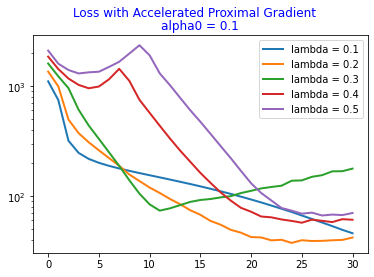

In [12]:
# accelerated proximal gradient
# Although changing the value of lambda does not improve an algorithm, we comment that for a specific algorithm,
# different values of lambda may affect the performance, but the pattern should not vary too much.
import matplotlib.pyplot as plt

lambds = np.linspace(0.1,0.5,5)
lambds = np.around(lambds, decimals=3)
maxit = 30
beta = 0.5
alpha0 = 1000
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Accelerated Proximal Gradient",color='b')
plt.title("alpha0 = 0.1",color='b')
loss_accel  = np.zeros((n,len(lambds)))
for i,lambd in enumerate(lambds):
    xa,la,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'lambda = ' + str(lambd)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
plt.savefig("accel-Lambd-0105-a0-01.png")

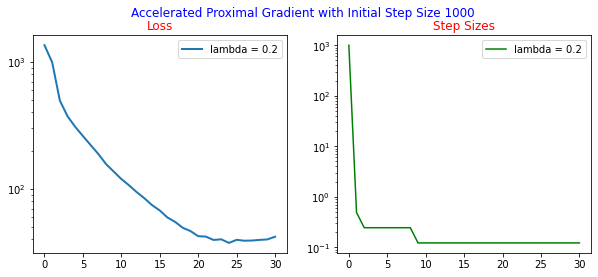

In [25]:
lambd = 0.2
maxit = 30
beta = 0.5
alpha0 = 1000
fig = plt.figure(figsize = (10,4))
ax1 = fig.add_subplot(121)
xa,la,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
labl = 'lambda = ' + str(lambd)
ax1.semilogy(la,linewidth=2,label = labl)
ax1.legend(loc="best")
plt.suptitle("Accelerated Proximal Gradient with Initial Step Size 1000",color='b')
plt.title("Loss",color='r')
ax2 = fig.add_subplot(122)
ax2.semilogy(step_size_accel,color='g',label=labl)
ax2.legend(loc='best')
plt.title("Step Sizes", color='r')
plt.savefig("accel-prox-grad-alpha0-1000.png")

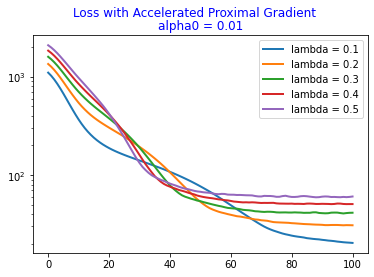

In [10]:
import matplotlib.pyplot as plt

lambds = np.linspace(0.1,0.5,5)
lambds = np.around(lambds, decimals=3)
maxit = 100
beta = 0.5
alpha0 = 0.01
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Accelerated Proximal Gradient",color='b')
plt.title("alpha0 = 0.01",color='b')
loss_accel  = np.zeros((n,len(lambds)))
for i,lambd in enumerate(lambds):
    xa,la,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'lambda = ' + str(lambd)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
plt.savefig("accel-Lambd-0105-a0-001.png")

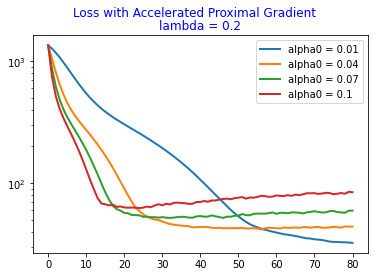

In [11]:
import matplotlib.pyplot as plt
lambd = 0.2
maxit = 80
beta = 0.5
alphas = np.linspace(0.01,0.1,4)
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Accelerated Proximal Gradient",color='b')
plt.title("lambda = 0.2",color='b')
for i,alpha0 in enumerate(alphas):
    xa,la,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'alpha0 = ' + str(alpha0)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
plt.savefig("accel-Lambd-02-a0-00101.png")

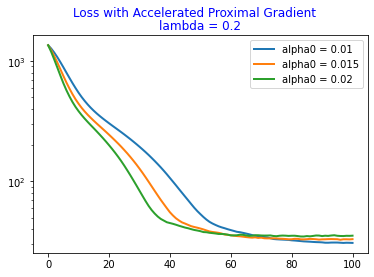

In [12]:
import matplotlib.pyplot as plt
lambd = 0.2
maxit = 100
beta = 0.5
alphas = np.linspace(0.01,0.02,3)
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Accelerated Proximal Gradient",color='b')
plt.title("lambda = 0.2",color='b')
for i,alpha0 in enumerate(alphas):
    xa,la,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'alpha0 = ' + str(alpha0)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
plt.savefig("accel-Lambd-02-a0-0010015002.png")

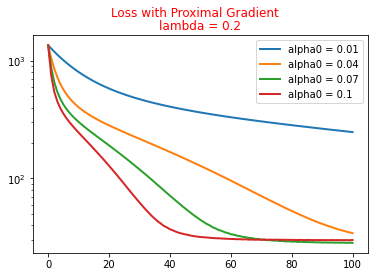

In [13]:
import matplotlib.pyplot as plt
lambd = 0.2
maxit = 100
beta = 0.5
alphas = np.linspace(0.01,0.1,4)
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Proximal Gradient",color='r')
plt.title("lambda = 0.2",color='r')
for i,alpha0 in enumerate(alphas):
    xa,la,step_size_accel = prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'alpha0 = ' + str(alpha0)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
plt.savefig("prox-Lambd-02-a0-00101.png")

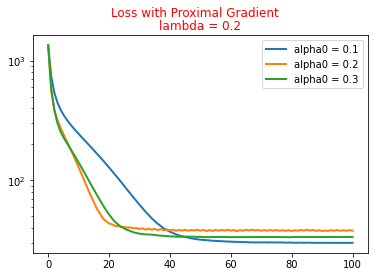

In [14]:
import matplotlib.pyplot as plt
lambd = 0.2
maxit = 100
beta = 0.5
alphas = np.linspace(0.1,0.3,3)
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(111)
plt.suptitle("Loss with Proximal Gradient",color='r')
plt.title("lambda = 0.2",color='r')
for i,alpha0 in enumerate(alphas):
    xa,la,step_size_accel = prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
    labl = 'alpha0 = ' + str(alpha0)
    ax.semilogy(la,linewidth=2,label = labl)
ax.legend(loc="best")
# plt.savefig("prox-Lambd-02-a0-010203.png")

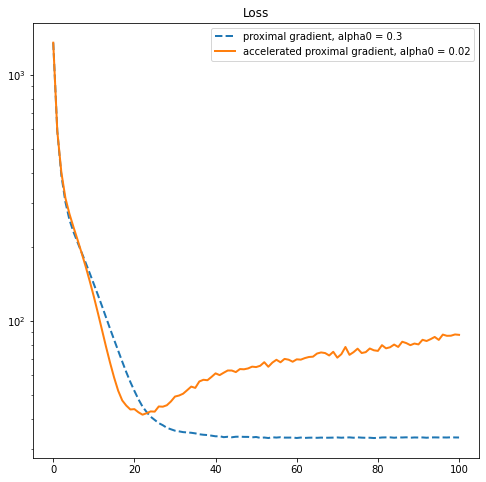

In [19]:
# proximal grad and accelerated proximal grad
lambd = 0.2
maxit = 100
beta = 0.5
alpha0_accel = 0.02
alpha0_prox = 0.3
x_proxGrad,loss_proxGrad,step_size_proxGrad = prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
x_accel,loss_accel,step_size_accel = accel_prox_grad_lasso(A,b,x0,alpha0,lambd,maxit=maxit,beta=beta)
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax1.semilogy(loss_proxGrad,'--',linewidth=2,label="proximal gradient, alpha0 = 0.3")
ax1.semilogy(loss_accel,linewidth=2,label = "accelerated proximal gradient, alpha0 = 0.02")
plt.title('Loss')
# plt.subtitle()
ax1.legend()
plt.savefig('accel-vs-prox.png')